# Entraînement du Modèle de Prédiction de la Qualité du Sommeil

Ce notebook implémente l'entraînement et l'évaluation du modèle de prédiction de la qualité du sommeil.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

/Users/ines/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Chargement des Données Prétraitées

In [2]:
# Charger les données
df = pd.read_csv('../data/sleep_data_processed.csv')
print('Dimensions du dataset:', df.shape)

Dimensions du dataset: (15, 15)


## 2. Préparation des Features

In [3]:
# Définir les features
features = [
    'Age', 'Sleep Duration', 'Physical Activity Level',
    'Stress Level', 'Heart Rate', 'Daily Steps',
    'Gender_num', 'Blood_Pressure_num'
]

X = df[features]
y = df['Quality of Sleep']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir en DataFrame pour garder les noms des colonnes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Configuration des Modèles

In [4]:
# Paramètres pour Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Paramètres pour Gradient Boosting
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

## 4. Entraînement et Optimisation

In [5]:
# Fonction d'entraînement avec GridSearchCV
def train_model(model, params, X, y, name):
    grid_search = GridSearchCV(
        model,
        params,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    print(f'\nRésultats pour {name}:')
    print(f'Meilleurs paramètres: {grid_search.best_params_}')
    print(f'Meilleur score R²: {grid_search.best_score_:.3f}')
    
    return grid_search.best_estimator_, grid_search.best_params_

# Entraîner Random Forest
rf_model, rf_best_params = train_model(
    RandomForestRegressor(random_state=42),
    rf_params,
    X_train_scaled,
    y_train,
    'Random Forest'
)

# Entraîner Gradient Boosting
gb_model, gb_best_params = train_model(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    X_train_scaled,
    y_train,
    'Gradient Boosting'
)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/ines/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ines/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ines/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ines/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ines/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or


Résultats pour Random Forest:
Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score R²: 0.841
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Résultats pour Gradient Boosting:
Meilleurs paramètres: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Meilleur score R²: 0.950


## 5. Évaluation des Modèles

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f'\nÉvaluation de {name}:')
    print(f'Train RMSE: {train_rmse:.3f}')
    print(f'Test RMSE: {test_rmse:.3f}')
    print(f'Train R²: {train_r2:.3f}')
    print(f'Test R²: {test_r2:.3f}')
    
    return {
        'train_metrics': {'rmse': train_rmse, 'r2': train_r2},
        'test_metrics': {'rmse': test_rmse, 'r2': test_r2}
    }

# Évaluer les modèles
rf_metrics = evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, 'Random Forest')
gb_metrics = evaluate_model(gb_model, X_train_scaled, y_train, X_test_scaled, y_test, 'Gradient Boosting')


Évaluation de Random Forest:
Train RMSE: 0.262
Test RMSE: 0.643
Train R²: 0.976
Test R²: 0.735

Évaluation de Gradient Boosting:
Train RMSE: 0.000
Test RMSE: 0.934
Train R²: 1.000
Test R²: 0.440


## 6. Importance des Features

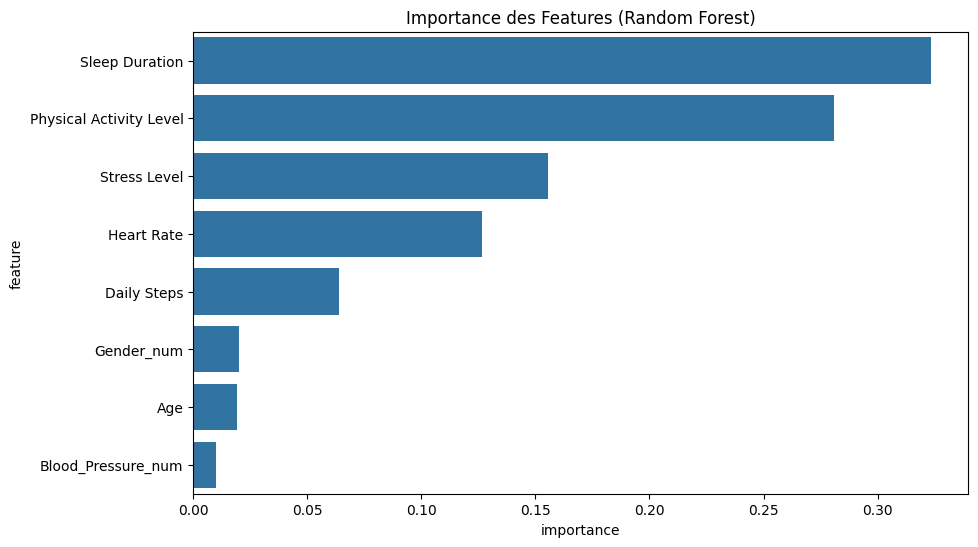

In [7]:
# Visualiser l'importance des features pour Random Forest
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importance des Features (Random Forest)')
plt.show()

## 7. Sauvegarde du Meilleur Modèle

In [ ]:
# Sélectionner le meilleur modèle basé sur le R² de test
if rf_metrics['test_metrics']['r2'] > gb_metrics['test_metrics']['r2']:
    best_model = rf_model
    best_params = rf_best_params
    best_metrics = rf_metrics
    model_name = 'random_forest'
else:
    best_model = gb_model
    best_params = gb_best_params
    best_metrics = gb_metrics
    model_name = 'gradient_boosting'

# Sauvegarder le modèle
joblib.dump(best_model, f'../models/saved_models/best_{model_name}_model.joblib')
joblib.dump(scaler, '../models/saved_models/scaler.joblib')

# Sauvegarder la liste des features
with open('../models/saved_models/feature_list.txt', 'w') as f:
    f.write('\n'.join(features))

# Sauvegarder les métriques
metrics = {
    'model_name': model_name,
    'best_parameters': best_params,
    'train_metrics': best_metrics['train_metrics'],
    'test_metrics': best_metrics['test_metrics'],
    'features': features
}

with open(f'../models/saved_models/{model_name}_model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print(f'\nMeilleur modèle ({model_name}) sauvegardé avec succès!')